## Setup

First, we set up our notebook by downloading the appropriate packages

### Dependencies

In [1]:
pip install matplotlib scipy pandas numpy networkx seaborn scikit-learn cython

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/41/f1/115e7c79b4506b4f0533acba742babd9718ff92eeca6d4205843173b6173/matplotlib-3.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/89/bb/80c9c98d887c855710fd31fc5ae5574133e98203b3475b07579251803662/scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 690.6 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7ddd7e3f6/pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/d1/27/2a7bd6855dc717aeec5f553073a3c426b9c816126555f8e616392eab856b/numpy-2.0.0-cp311-cp311-manyl

### Imports

In [2]:
# base libraries
import importlib
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import os

import networkx as nx

import time

from IPython.utils.io import capture_output # supress outputs

from sklearn.metrics.cluster import adjusted_rand_score

### Fix pathway

In [3]:
# fix directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

print("Current working directory:", os.getcwd())

from trcrpm.src import Hierarchical_TRCRP_Mixture, TRCRP_Mixture

Current working directory: /hdsi-collab-persistent/cephfs/Setup


### Helper Functions

1. **`run_model(data, num_chains = 8, p = 5, MCMC_steps=1000, hyperparam_steps=50, runtime = True)`**
    - **Returns**: Fitted model
        - The dataframe index needs to be reset as an integer.
        - Choose a high number for `MCMC_steps` to allow for a burn-in period.
        - `p` is our lag window

2. **`post_dep(model, num_samples)`**
    - **Returns**: Pairwise posterior dependence matrices (cluster probabilities)
        - The array is of size `NUM_SAMPLES x NUM_CHAINS x LEN(DF) x LEN(DF)`

3. **`clustering(post_probs, threshold = 0.75)`**
    - **Returns**: Clusters
        - If time series `i` and `k` are dependent in `threshold%` of samples, they are clustered together.
        - Averages over `NUM_SAMPLES` and `NUM_CHAINS`.

4. **`return_ari(true_labels, predicted_clusters)`**
    - **Returns**: Adjusted Rand Index (ARI) if ground truth is available


In [4]:
import importlib

In [5]:
import experiments.helper_functions as helpers
importlib.reload(helpers)

<module 'experiments.helper_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/helper_functions.py'>

## Data Generation (Sin Waves)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,-0.604226,-0.326632,0.311259,0.534444,0.485116,0.840334,0.116422,0.427950,0.473753,0.184834
2,-0.221366,1.351233,-0.500593,1.828679,0.717070,0.888589,-0.105516,1.047797,-0.990852,1.666184
3,0.480436,1.109244,0.161641,1.909603,0.278430,1.527846,0.482483,2.001754,0.393093,2.590374
4,0.413255,2.109497,0.056744,1.790744,0.993200,2.297853,0.210718,1.347381,0.996559,2.026466


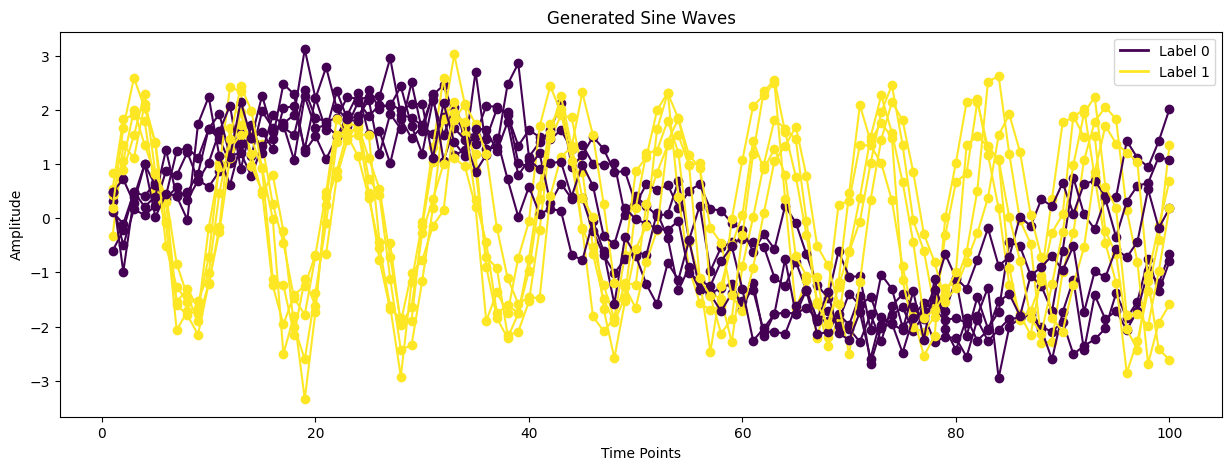

In [6]:
import experiments.data_generation as data_gen
importlib.reload(data_gen)

df = data_gen.generate_sine_wave_data(frequency_noise=0.1, random_state=42, use_colors = True, 
                                      num_samples = 10, fixed_amplitude = 2, num_clusters = 2)
df.head()

## Run Analysis

In [7]:
data = df.iloc[1:]
labels = df.iloc[0].values

print(data.shape) # NUM_OBSERVATIONS X NUM_TIMESEREIES

(100, 10)


In [8]:
model = helpers.run_model(data)

MCMC inference time: 1 minutes and 22 seconds
Hyperparameter optimization time: 0 minutes and 53 seconds


In [9]:
dep_matrices = helpers.post_dep(model, 20)

Sampling Time: 0 minutes and 28 seconds


In [10]:
# compare predicted and true clusters

In [11]:
predicted_clusters = helpers.clustering(dep_matrices, threshold = 0.75)
predicted_clusters

[{0, 2, 4, 6, 8}, {1, 3, 5, 7, 9}]

In [12]:
helpers.return_ari(labels, predicted_clusters)

1.0

In [13]:
unique_labels = np.unique(labels)
# step size (number of elements per cluster)
step = len(labels) // len(unique_labels)

# clusters as list 
clusters = [[int(label) for label in np.where(labels == label)[0]] for label in unique_labels]
clusters

[[0, 2, 4, 6, 8], [1, 3, 5, 7, 9]]

## Plotting


In [14]:
import plotting_functions as plot
importlib.reload(plot)

<module 'plotting_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/plotting_functions.py'>

In [ ]:
# %%capture
# # need to simulate samples for confidence interval
# # we sample from the posterior to get confidence interval for forecasted values
# # some bug inside .simulate so supressing outputs for now
# # bug is in cgpm.src.crosscat.sampling (print statement in simulate_row)
# probes = model.dataset.index
# numsamples = 10
# samples = model.simulate(probes, model.variables, numsamples)

### Helper Functions 

In [ ]:
# compare labels with predicted_labels
plot.plot_df(data, labels)
plot.plot_df(data, predicted_labels)

In [ ]:
plot.plot_cluster_variables(samples, [1, 6, 26, 41], ax, states_from_chain=2)


### Serialize 

In [ ]:
metadata = model.to_metadata()

In [ ]:
# from collections import OrderedDict
# def convert_to_serializable(obj):
#     if isinstance(obj, dict):
#         return {key: convert_to_serializable(value) for key, value in obj.items()}
#     elif isinstance(obj, list):
#         return [convert_to_serializable(item) for item in obj]
#     elif isinstance(obj, tuple):
#         return tuple(convert_to_serializable(item) for item in obj)
#     elif isinstance(obj, set):
#         return list(convert_to_serializable(item) for item in obj)
#     elif isinstance(obj, OrderedDict):  # Handling OrderedDict specifically
#         return list(obj.items())
#     else:
#         return obj

# # Convert metadata to a serializable format
# serializable_metadata = convert_to_serializable(metadata)

# # Now you can serialize it
# json_metadata = json.dumpfs(serializable_metadata)
# print(json_metadata)

In [ ]:
# metadata['engine']

In [ ]:
import json
json_metadaata = json.dumps(metadata)

In [ ]:
modname, attrname = metadata['factory']

In [ ]:
module = importlib.import_module(modname + '.src') 

In [ ]:
module

In [ ]:
klass = getattr(module, attrname)

In [ ]:
model2 = klass.from_metadata(